Problem statement: Prediction of Airplane crash type. Multiclassification problem.\
Link to the leaderboard and hackathon given in website in description.\
The final model fared 27 amongst 7449 participants.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [0]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [0]:
df=pd.read_csv('train.csv')

In [0]:
df.head()

,Severity,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID
0,Minor_Damage_And_Injuries,49.223744,14,22,71.285324,0.272118,78.04,2,31335.476824,3,0.424352,7570
1,Minor_Damage_And_Injuries,62.465753,10,27,72.288058,0.423939,84.54,2,26024.711057,2,0.352350,12128
2,Significant_Damage_And_Fatalities,63.059361,13,16,66.362808,0.322604,78.86,7,39269.053927,3,0.003364,2181
3,Significant_Damage_And_Serious_Injuries,48.082192,11,9,74.703737,0.337029,81.79,3,42771.499200,1,0.211728,5946
4,Significant_Damage_And_Fatalities,26.484018,13,25,47.948952,0.541140,77.16,3,35509.228515,2,0.176883,9054


In [0]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Safety_Score,10000.0,41.876406,16.138072,0.000000,30.593607,41.278539,52.511416,100.000000
Days_Since_Inspection,10000.0,12.931100,3.539803,1.000000,11.000000,13.000000,15.000000,23.000000
Total_Safety_Complaints,10000.0,6.564300,6.971982,0.000000,2.000000,4.000000,9.000000,54.000000
Control_Metric,10000.0,65.145324,11.882934,0.000000,56.927985,65.587967,73.336372,100.000000
Turbulence_In_gforces,10000.0,0.381495,0.121301,0.134000,0.293665,0.365879,0.451346,0.882648
Cabin_Temperature,10000.0,79.969331,2.759739,74.740000,77.960000,79.540000,81.560000,97.510000
Accident_Type_Code,10000.0,3.814900,1.902577,1.000000,2.000000,4.000000,5.000000,7.000000
Max_Elevation,10000.0,32001.803282,9431.995196,831.695553,25757.636908,32060.336419,38380.641513,64297.651218
Violations,10000.0,2.012200,1.039980,0.000000,1.000000,2.000000,3.000000,5.000000
Adverse_Weather_Metric,10000.0,0.255635,0.381128,0.000316,0.012063,0.074467,0.354059,2.365378


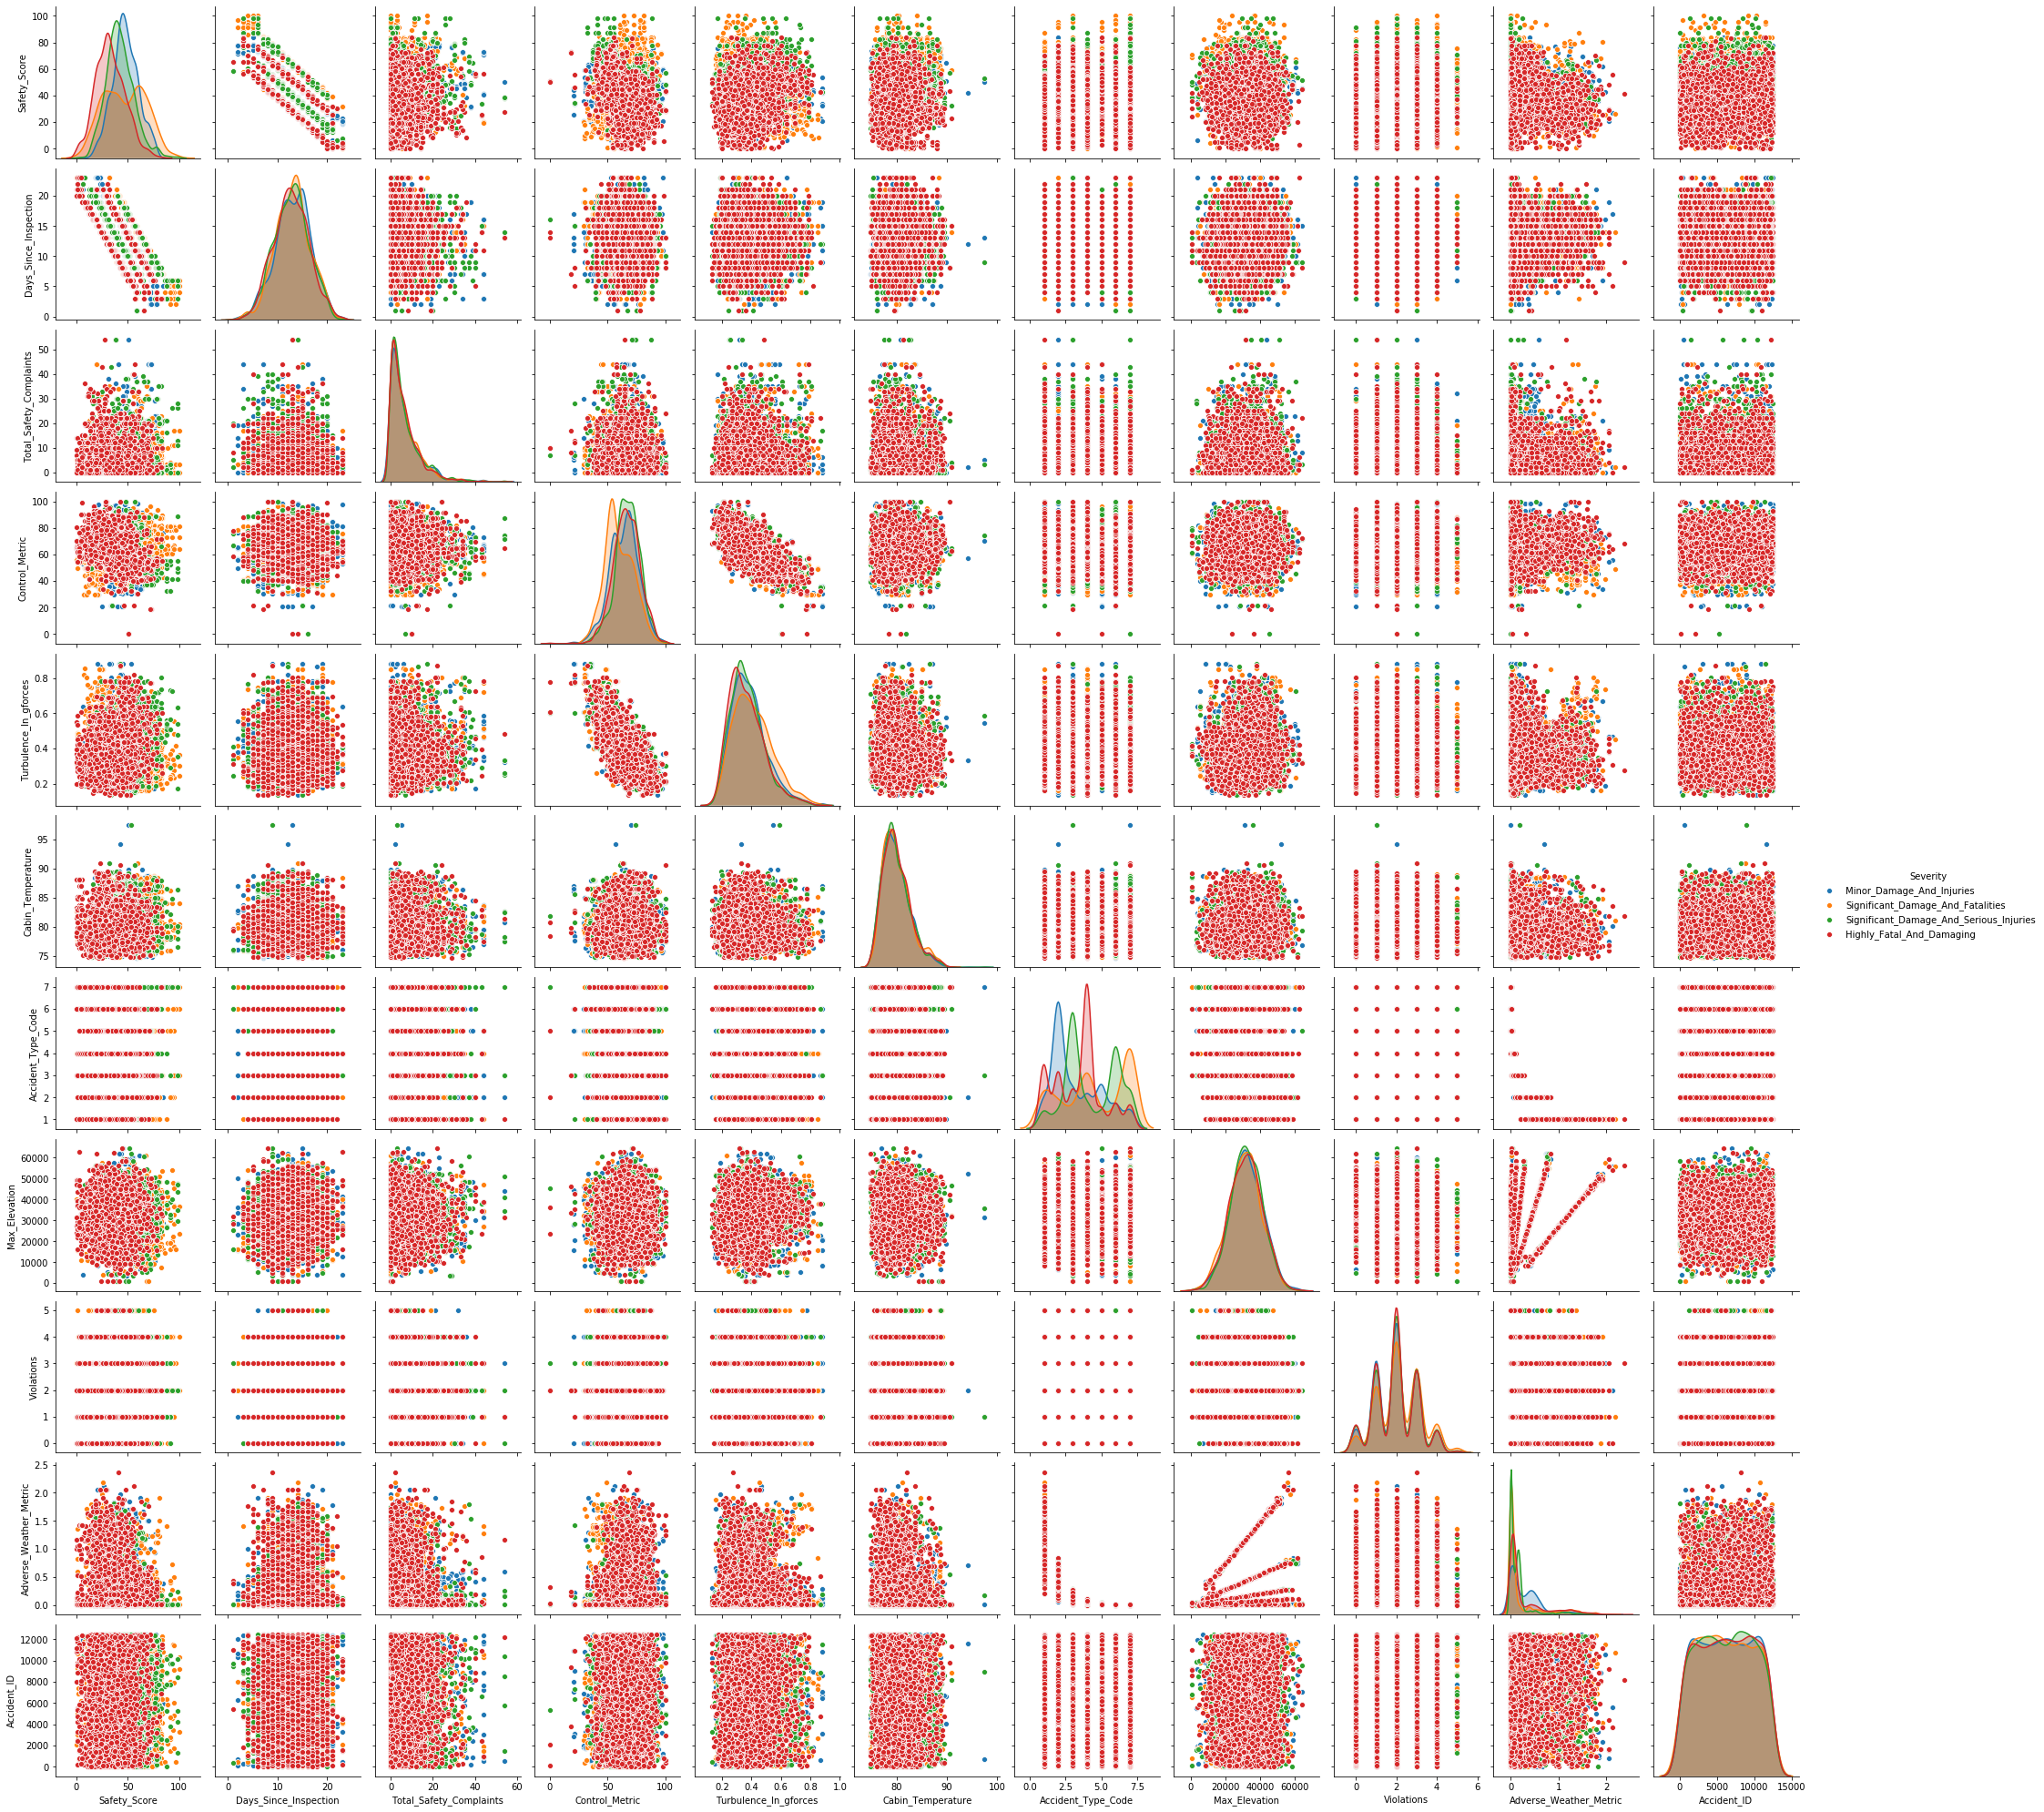

In [0]:
sns.pairplot(df,hue='Severity',diag_kind='kde')

We can drop some features straightaway which show very low variance, like max_elevation, cabin temp and total safety complains, but we'll confirm with Random Forest's feature importance later.


Check for data balancing:

In [0]:
df['Severity'].value_counts(normalize=True)

Highly_Fatal_And_Damaging                  0.3049
Significant_Damage_And_Serious_Injuries    0.2729
Minor_Damage_And_Injuries                  0.2527
Significant_Damage_And_Fatalities          0.1695
Name: Severity, dtype: float64

Scaling and fitting a standard Random Forest with cross validation. Checking random forest feature imprtance.

In [0]:
pipe = Pipeline((
("scaler", StandardScaler()),
("rf", RandomForestClassifier()),
))

In [0]:
X=df.drop(['Severity','Accident_ID'],axis=1)
y=df['Severity']

In [0]:
scorescv = cross_val_score(pipe, X, y, cv=10,scoring='f1_macro')

In [0]:
scorescv.mean()

0.9380387755594741

In [0]:
scorescv.std()

0.005985916399580765

In [0]:
sc=StandardScaler()
scaledX = sc.fit_transform(X)

In [0]:
rf=RandomForestClassifier()
rf.fit(scaledX,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

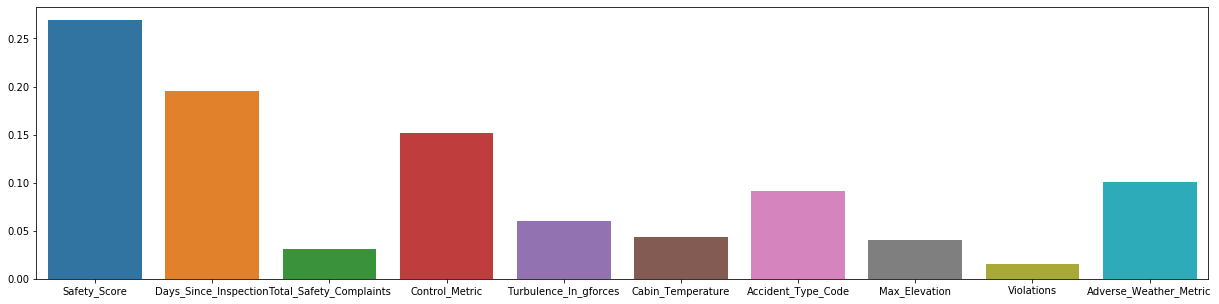

In [0]:
plt.figure(figsize=(21,5))
cols=X.columns
imp=rf.feature_importances_
sns.barplot(cols,imp)

Inference: We can definitely see Safety Score to be a very importance feature. Low importance features: Total_Safety_complaints,Cabin Temp,Max_elevation can be dropped. Violations is a categorical variable which can be one hot encoded and then Accordingly some categories not contributing can be dropped.

In [0]:
Xtest=df_test.drop('Accident_ID',axis=1)
scaledXtest=sc.transform(Xtest)

In [0]:
df_test['Severity']=rf.predict(scaledXtest)

In [0]:
df_upload=df_test[['Accident_ID','Severity']]


In [0]:
df_upload.head(10)

,Accident_ID,Severity
0,1,Highly_Fatal_And_Damaging
1,10,Significant_Damage_And_Fatalities
2,14,Significant_Damage_And_Serious_Injuries
3,17,Highly_Fatal_And_Damaging
4,21,Significant_Damage_And_Fatalities
5,40,Significant_Damage_And_Fatalities
6,45,Significant_Damage_And_Fatalities
7,50,Highly_Fatal_And_Damaging
8,52,Highly_Fatal_And_Damaging
9,85,Significant_Damage_And_Serious_Injuries


In [0]:
df_upload.to_csv('upload.csv') #First upload of the hackathon

Continuing with dropping features to reduce redundancy and checking increase in score.

In [0]:
X=df.drop(['Severity','Accident_ID','Total_Safety_Complaints','Cabin_Temperature','Max_Elevation'],axis=1)
y=df['Severity']

In [0]:
from xgboost import XGBClassifier

In [0]:
pipe = Pipeline((
("scaler", StandardScaler()),
("XGB", XGBClassifier()),
))

In [0]:
scorescv_xgb = cross_val_score(pipe, X, y, cv=10,scoring='f1_macro')

In [0]:
scorescv_xgb

array([0.84307507, 0.83546948, 0.82797425, 0.83965952, 0.83503631,
       0.83484156, 0.83801569, 0.8399648 , 0.84341791, 0.81265352])

In [0]:
scorescv_xgb.mean()

0.8350108105271575

one hot encoding of Accident type code

In [0]:
test = pd.read_csv("test.csv",index_col='Accident_ID')
train = pd.read_csv("train.csv",index_col='Accident_ID')
train=train.drop(['Total_Safety_Complaints','Cabin_Temperature','Max_Elevation','Violations'],axis=1)
test=test.drop(['Total_Safety_Complaints','Cabin_Temperature','Max_Elevation','Violations'],axis=1)

In [0]:
dummy_train=pd.get_dummies(train['Accident_Type_Code'])
dummy_test=pd.get_dummies(test['Accident_Type_Code'])
train=train.drop('Accident_Type_Code',axis=1)
test=test.drop('Accident_Type_Code',axis=1)
train['accident_1'] = dummy_train[1]
train['accident_2'] = dummy_train[2]
train['accident_3'] = dummy_train[3]
train['accident_4'] = dummy_train[4]
train['accident_5'] = dummy_train[5]
train['accident_6'] = dummy_train[6]
train['accident_7'] = dummy_train[7]
test['accident_1'] = dummy_test[1]
test['accident_2'] = dummy_test[2]
test['accident_3'] = dummy_test[3]
test['accident_4'] = dummy_test[4]
test['accident_5'] = dummy_test[5]
test['accident_6'] = dummy_test[6]
test['accident_7'] = dummy_test[7]

In [0]:
x=train.drop('Severity',axis=1)
y=train['Severity']

In [0]:
l_quan=['Safety_Score','Adverse_Weather_Metric','Control_Metric','Turbulence_In_gforces']
l_cato=['Days_Since_Inspection','Accident_Type_Code'] #seperating numerical and categorical variables

Checking normality of distribution for transformation if required

Safety_Score


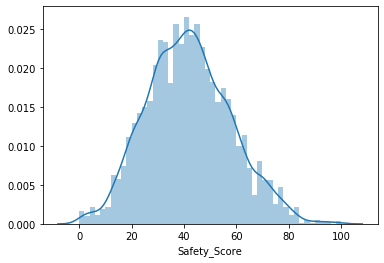

Adverse_Weather_Metric


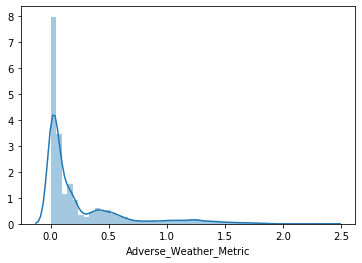

Control_Metric


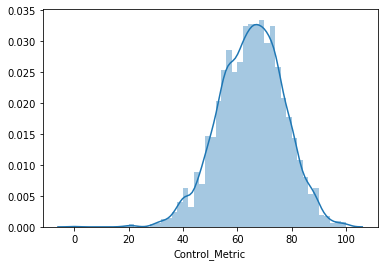

Turbulence_In_gforces


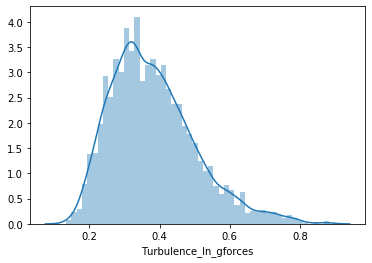

In [0]:
for a in l_quan:
    print(a)
    sns.distplot(x[a])
    plt.show()

Applying sqrt transformation to Adverse_Weather_Metric

In [0]:
x['Adverse_Weather_Metric']=np.sqrt(x['Adverse_Weather_Metric'])

In [0]:
test['Adverse_Weather_Metric']=np.sqrt(test['Adverse_Weather_Metric'])

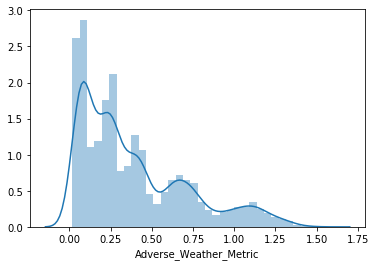

In [0]:
sns.distplot(x['Adverse_Weather_Metric'])

In [0]:
#x['Days_Since_Inspection'] = np.power(1.2, x['Days_Since_Inspection'])
#x['Safety_Score'] = np.power(1.2, x['Safety_Score'])
#test['Days_Since_Inspection'] = np.power(1.2, test['Days_Since_Inspection'])
#test['Safety_Score'] = np.power(1.2, test['Safety_Score'])

In [0]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler().fit(x[l_quan])

In [0]:
x_quan=pd.DataFrame(ss.transform(x[l_quan]),columns=l_quan,index=x.index)
x[l_quan]=x_quan
x.head()

,Safety_Score,Days_Since_Inspection,Control_Metric,Turbulence_In_gforces,Accident_Type_Code,Adverse_Weather_Metric
Accident_ID,,,,,,
7570,0.455303,14,0.516733,-0.901749,2,0.812648
12128,1.275888,10,0.601122,0.349922,2,0.634673
2181,1.312673,13,0.102462,-0.485516,7,-1.013575
5946,0.384562,11,0.804422,-0.366593,3,0.223985
9054,-0.953841,13,-1.447221,1.316177,3,0.102228


In [0]:
test_quan=pd.DataFrame(ss.transform(test[l_quan]),columns=l_quan,index=test.index)
test[l_quan]=test_quan
test.head()

,Safety_Score,Days_Since_Inspection,Control_Metric,Turbulence_In_gforces,Accident_Type_Code,Adverse_Weather_Metric,Severity
Accident_ID,,,,,,,
1,-1.386771,16,0.589614,0.061532,4,-0.379642,Highly_Fatal_And_Damaging
10,1.009905,15,-0.047136,-1.077161,7,-1.029880,Significant_Damage_And_Fatalities
14,-0.532230,15,-0.035629,-0.369566,6,-0.989879,Significant_Damage_And_Serious_Injuries
17,-2.391281,21,0.102462,0.332084,3,0.184174,Highly_Fatal_And_Damaging
21,-1.921566,18,-0.760604,-0.562817,2,0.948238,Significant_Damage_And_Fatalities


Checking model performance of KNC:

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [0]:
score=[]
for i in [2,4,5,7,9]:
  knc=KNeighborsClassifier(i)
  cvscore=cross_val_score(knc,x,y,cv=3,scoring='f1_weighted')
  score.append(cvscore.mean())

In [0]:
score

[0.8136724205999629,
 0.8036115781542809,
 0.7950481353911192,
 0.7843460969399322,
 0.7775180718439315]

Iterating the same code to check mutiple models. Sticking with gradient boosting because the base model was giving a good f1 score.

Trying to use Randomised search as GridSearch took a long time to run. 

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
gbc=GradientBoostingClassifier()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [0]:
parameters = {
    "n_estimators":[300,400,500],
    "learning_rate": [0.01,0.1, 0.2],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "subsample":[0.5,0.8, 1.0],
    }

In [0]:
clf = RandomizedSearchCV(gbc, parameters, random_state=1, n_iter=15, cv=3, verbose=0, n_jobs=-1)

In [0]:
clf = GridSearchCV(gbc, parameters,cv=3, scoring='f1_weighted')

In [0]:
clf.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [0]:
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))
print(clf.best_params_)

1.0
0.9533333333333334
{'subsample': 1.0, 'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.2}


In [0]:
print(clf.best_params_)

{'subsample': 1.0, 'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.2}


In [0]:
gbc=GradientBoostingClassifier(learning_rate= 0.2,max_depth= 5,n_estimators=300,max_features='sqrt')
parameters={"min_samples_split":[10,100,500], "min_samples_leaf":[50,100]}
clf = GridSearchCV(gbc, parameters,cv=3, scoring='f1_weighted')

In [0]:
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.2,
                                                  loss='deviance', max_depth=5,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=300,
                                                  n_iter_no_change=None,
       

In [0]:
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))
print(clf.best_params_)

0.9998571466401404
0.9479956234614461
{'min_samples_leaf': 50, 'min_samples_split': 10}


In [0]:
gbc=GradientBoostingClassifier(learning_rate= 0.1,max_depth= 5,n_estimators=1000,max_features='sqrt',subsample=1.0)

In [0]:
cvscore=cross_val_score(gbc,x,y,cv=4,scoring='f1_weighted')

In [0]:
cvscore

array([0.94994634, 0.94917455, 0.95120728, 0.95599568])

In [0]:
cvscore.mean()

0.9503995021901916

In [0]:
gbc.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=270,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [0]:
gbc.score(X_train,y_train)

1.0

In [0]:
gbc.score(X_test,y_test)

0.947

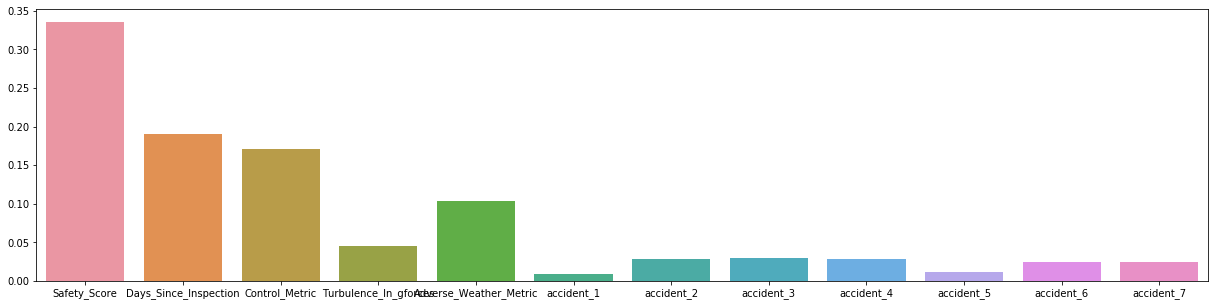

In [0]:
#feature importance using Gradient boost show some less important dummy variables
plt.figure(figsize=(21,5))
cols=x.columns
imp=gbc.feature_importances_
sns.barplot(cols,imp)

Trying to oversample/undersample data to check increase in model performance.

In [0]:
from imblearn.under_sampling import NearMiss,RandomUnderSampler

In [0]:
rus = RandomUnderSampler()
x_sampled, y_sampled = rus.fit_sample(x, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
x_sampled

array([[-0.84631619, 13.        , -0.3079741 ,  0.55209222,  1.        ,
         2.68845338],
       [-0.09930021,  9.        , -0.4997665 ,  0.88507837,  2.        ,
         0.61951654],
       [-1.05287743, 14.        , -0.55730422,  0.09720936,  4.        ,
        -0.42495233],
       ...,
       [ 0.41851768, 10.        ,  1.41048581, -1.27635849,  3.        ,
         0.07150982],
       [ 0.72411513, 16.        , -1.80779067,  0.15964426,  6.        ,
        -0.88908761],
       [-0.73030235, 16.        ,  0.28274649,  0.15667117,  6.        ,
        -1.01900092]])

In [0]:
gbc=GradientBoostingClassifier(learning_rate= 0.1,max_depth= 5,n_estimators=1000,max_features='sqrt',subsample=1.0)

In [0]:
cvscore=cross_val_score(gbc,pd.DataFrame(x_sampled),y_sampled,cv=4,scoring='f1_weighted')

In [0]:
cvscore

array([0.95505266, 0.95677573, 0.95270862, 0.96223605])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=99)

In [0]:
gbc.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [0]:
gbc.score(X_train,y_train)

1.0

In [0]:
gbc.score(X_test,y_test)

0.956

In [0]:
gbc.fit(pd.DataFrame(x_sampled),y_sampled)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [0]:
test.head()

,Safety_Score,Days_Since_Inspection,Control_Metric,Turbulence_In_gforces,Accident_Type_Code,Adverse_Weather_Metric,Severity
Accident_ID,,,,,,,
1,-1.386771,16,0.589614,0.061532,4,-0.379642,Highly_Fatal_And_Damaging
10,1.009905,15,-0.047136,-1.077161,7,-1.029880,Significant_Damage_And_Fatalities
14,-0.532230,15,-0.035629,-0.369566,6,-0.989879,Significant_Damage_And_Serious_Injuries
17,-2.391281,21,0.102462,0.332084,3,0.184174,Highly_Fatal_And_Damaging
21,-1.921566,18,-0.760604,-0.562817,2,0.948238,Significant_Damage_And_Fatalities


In [0]:
submission=gbc.predict(test.drop('Severity',axis=1)) 

In [0]:
submission

array(['Highly_Fatal_And_Damaging', 'Significant_Damage_And_Fatalities',
       'Significant_Damage_And_Serious_Injuries', ...,
       'Significant_Damage_And_Serious_Injuries',
       'Significant_Damage_And_Serious_Injuries',
       'Highly_Fatal_And_Damaging'], dtype=object)

In [0]:
test['Severity']=submission

In [0]:
submit=test.reset_index()[['Accident_ID','Severity']]

In [0]:
submit.to_csv('sample_submission_gb_8.csv') #After several uploads

In [0]:
x.head()

,Safety_Score,Days_Since_Inspection,Control_Metric,Turbulence_In_gforces,Adverse_Weather_Metric,accident_1,accident_2,accident_3,accident_4,accident_5,accident_6,accident_7
Accident_ID,,,,,,,,,,,,
7570,0.455303,14,0.516733,-0.901749,0.957777,0,1,0,0,0,0,0
12128,1.275888,10,0.601122,0.349922,0.861378,0,1,0,0,0,0,0
2181,1.312673,13,0.102462,-0.485516,-1.550182,0,0,0,0,0,0,1
5946,0.384562,11,0.804422,-0.366593,0.597322,0,0,1,0,0,0,0
9054,-0.953841,13,-1.447221,1.316177,0.504099,0,0,1,0,0,0,0


In [0]:
test.head()

,Safety_Score,Days_Since_Inspection,Control_Metric,Turbulence_In_gforces,Adverse_Weather_Metric,accident_1,accident_2,accident_3,accident_4,accident_5,accident_6,accident_7,Severity
Accident_ID,,,,,,,,,,,,,
1,-1.386771,16,0.589614,0.061532,0.021220,0,0,0,1,0,0,0,Highly_Fatal_And_Damaging
10,1.009905,15,-0.047136,-1.077161,-1.649510,0,0,0,0,0,0,1,Significant_Damage_And_Fatalities
14,-0.532230,15,-0.035629,-0.369566,-1.420925,0,0,0,0,0,1,0,Significant_Damage_And_Serious_Injuries
17,-2.391281,21,0.102462,0.332084,0.567753,0,0,1,0,0,0,0,Significant_Damage_And_Serious_Injuries
21,-1.921566,18,-0.760604,-0.562817,1.025638,0,1,0,0,0,0,0,Significant_Damage_And_Fatalities


Sampling the data actually reduced the score reason being data gets very small due to the minority class which is very small. Similarly oversampling synthetically was ineffctive.

Trying out LGBM. LGBM and Gradient boosting are very similar algorithms but LGBM is faster and light on the processors.

In [0]:
from lightgbm import LGBMClassifier

In [0]:
lgbm=LGBMClassifier(boosting='gbdt',learning_rate= 0.1,max_depth= 5,n_estimators=1000,max_features='sqrt',subsample=1.0)

In [0]:
cvscore=cross_val_score(lgbm,x,y,cv=4,scoring='f1_weighted')

In [0]:
cvscore

array([0.95836012, 0.95717668, 0.96000951, 0.96718051])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=99)
lgbm.fit(X_train,y_train)

LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_weight=None,
               colsample_bytree=1.0, importance_type='split', learning_rate=0.2,
               max_depth=5, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=1200, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [0]:
print(lgbm.score(X_train,y_train))
print(lgbm.score(X_test,y_test)) #problem of overfitting was a big problem even while submitting 

1.0
0.9613333333333334


In [0]:
lgbm.fit(x,y)
submission=lgbm.predict(test)

In [0]:
test['Severity']=submission
submit=test.reset_index()[['Accident_ID','Severity']]
submit.to_csv('sample_submission_lgbm_3.csv')

In [0]:
rf = RandomForestClassifier()

In [0]:
cvscore=cross_val_score(rf,x,y,cv=8,scoring='f1_weighted')
cvscore

array([0.91926263, 0.91049645, 0.9130643 , 0.92673481, 0.91781135,
       0.92488426, 0.92231362, 0.9193019 ])

In [0]:
cvscore.mean()

0.9225042172581385

In [0]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
rf.score(X_test,y_test)

0.9246666666666666

In [0]:
rf.score(X_train,y_train) #high overfitting.

1.0

In [0]:
test = pd.read_csv("test.csv",index_col='Accident_ID')
train = pd.read_csv("train.csv",index_col='Accident_ID')
train=train.drop(['Total_Safety_Complaints','Cabin_Temperature','Max_Elevation','Violations'],axis=1)
test=test.drop(['Total_Safety_Complaints','Cabin_Temperature','Max_Elevation','Violations'],axis=1)

In [0]:
x=train.drop('Severity',axis=1)
y=train.Severity

Trying to remove or cap the outliers and check model improvement. 

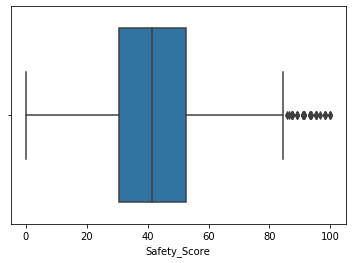

In [0]:
sns.boxplot(x['Safety_Score'])

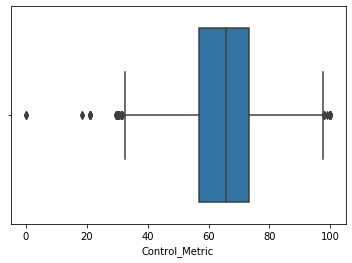

In [0]:
sns.boxplot(x['Control_Metric'])

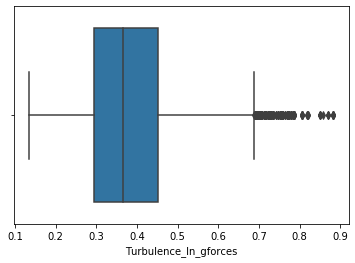

In [0]:
sns.boxplot(x['Turbulence_In_gforces'])

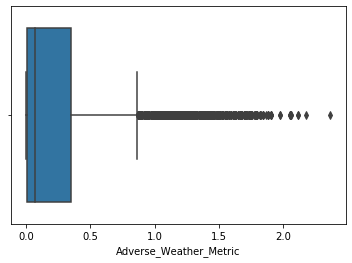

In [0]:
sns.boxplot(x['Adverse_Weather_Metric'])

In [0]:
x['Adverse_Weather_Metric']=np.sqrt(x['Adverse_Weather_Metric'])
test['Adverse_Weather_Metric']=np.sqrt(test['Adverse_Weather_Metric'])

In [0]:
df_numeric=x[['Safety_Score','Control_Metric','Turbulence_In_gforces','Adverse_Weather_Metric']]
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1
print(IQR)
x_out = df_numeric[~((df_numeric < (Q1 - 1.5 * IQR)) |(df_numeric > (Q3 + 1.5 * IQR))).any(axis=1)]
x_out.shape

Safety_Score              21.917808
Control_Metric            16.408387
Turbulence_In_gforces      0.157681
Adverse_Weather_Metric     0.485198
dtype: float64


(9665, 4)

In [0]:
x_tran=pd.concat([x.drop(['Safety_Score','Control_Metric','Turbulence_In_gforces','Adverse_Weather_Metric'],axis=1),x_out],axis=1).dropna()

In [0]:
y_tran=(pd.concat([y,x_out],axis=1).dropna())['Severity']
y_tran

Accident_ID
2                      Minor_Damage_And_Injuries
3              Significant_Damage_And_Fatalities
4                      Highly_Fatal_And_Damaging
5              Significant_Damage_And_Fatalities
6        Significant_Damage_And_Serious_Injuries
                          ...                   
12496    Significant_Damage_And_Serious_Injuries
12497    Significant_Damage_And_Serious_Injuries
12498                  Minor_Damage_And_Injuries
12499    Significant_Damage_And_Serious_Injuries
12500          Significant_Damage_And_Fatalities
Name: Severity, Length: 9665, dtype: object

Outlier treatment didnt significantly improve cross validation result also similar result after submitting.

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [0]:
gbc=GradientBoostingClassifier(learning_rate= 0.3,max_depth= 8,n_estimators=500,max_features='sqrt')
cvscore=cross_val_score(gbc,x_tran,y_tran,cv=4,scoring='f1_weighted')
cvscore

array([0.96814789, 0.95951208, 0.96440015, 0.95693496])

In [0]:
parameters = {
    "n_estimators":[300,500,800,1200],
    "learning_rate": [0.1,0.2,.4],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "subsample":[0.5,0.8, 1.0],
    }
clf = RandomizedSearchCV(gbc, parameters, random_state=1, n_iter=30, cv=3, verbose=0, n_jobs=-1)
clf.fit(x_tran, y_tran)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.3,
                                                        loss='deviance',
                                                        max_depth=8,
                                                        max_features='sqrt',
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                  

In [0]:
clf.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'max_features': 'sqrt',
 'n_estimators': 800,
 'subsample': 1.0}

In [0]:
gbc=GradientBoostingClassifier(learning_rate= 0.1,max_depth= 5,n_estimators=1000,max_features='sqrt',subsample=1.0)
cvscore=cross_val_score(gbc,x_tran,y_tran,cv=4,scoring='f1_weighted')
cvscore

array([0.97187213, 0.95825349, 0.96563681, 0.9598245 ])

In [0]:
gbc=GradientBoostingClassifier(learning_rate= 0.1,max_depth= 5,n_estimators=1000,max_features='sqrt',subsample=1.0)
gbc.fit(x_tran,y_tran)
submission=gbc.predict(test)
test['Severity']=submission
submit=test.reset_index()[['Accident_ID','Severity']]
submit.to_csv('sample_submission_gb_4.csv')

In [0]:
x_sca=x_tran.copy()
test_sca=test.copy()
from sklearn.preprocessing import StandardScaler
l_quan=['Safety_Score','Adverse_Weather_Metric','Control_Metric','Turbulence_In_gforces']
ss=StandardScaler().fit(x_sca[l_quan])
x_quan=pd.DataFrame(ss.transform(x_sca[l_quan]),columns=l_quan,index=x_sca.index)
x_sca[l_quan]=x_quan
test_quan=pd.DataFrame(ss.transform(test_sca[l_quan]),columns=l_quan,index=test_sca.index)
test_sca[l_quan]=test_quan

In [0]:
gbc=GradientBoostingClassifier(learning_rate= 0.1,max_depth= 5,n_estimators=1000,max_features='sqrt',subsample=1.0)
cvscore=cross_val_score(gbc,x_sca,y_tran,cv=7,scoring='f1_weighted')
cvscore

array([0.97827585, 0.97175699, 0.96452047, 0.95726187, 0.97029816,
       0.95718024, 0.95722708])

In [0]:
gbc=GradientBoostingClassifier(learning_rate= 0.1,max_depth= 5,n_estimators=1000,max_features='sqrt',subsample=1.0)
gbc.fit(x_sca,y_tran)
submission=gbc.predict(test_sca)
test['Severity']=submission
submit=test.reset_index()[['Accident_ID','Severity']]
submit.to_csv('sample_submission_gb_5.csv')

**Cleaning features and applying gbc**

In [0]:
from sklearn.preprocessing import PolynomialFeatures
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

In [0]:
test = pd.read_csv("test.csv",index_col='Accident_ID')
train = pd.read_csv("train.csv",index_col='Accident_ID')
train=train.drop(['Total_Safety_Complaints','Cabin_Temperature','Max_Elevation','Violations','Turbulence_In_gforces', 'Adverse_Weather_Metric'],axis=1)
test=test.drop(['Total_Safety_Complaints','Cabin_Temperature','Max_Elevation','Violations','Turbulence_In_gforces', 'Adverse_Weather_Metric'],axis=1)

Dropping features played an important role. This is a very important trick to increase f1 score. Less important features which play less important role in the algorithm upon removal helps work the tune algorithm better towards the betterment of f1 score. High f1 score means better prediction of minority classes also.

In [0]:
x=train.drop('Severity',axis=1)
y=train.Severity

^ tuning using randomized search.

Checking oversampling.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [0]:
sm = SMOTE(random_state=2)
x_res, y_res = sm.fit_sample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
pd.Series(y_res).value_counts()

Highly_Fatal_And_Damaging                  2295
Minor_Damage_And_Injuries                  2295
Significant_Damage_And_Serious_Injuries    2295
Significant_Damage_And_Fatalities          2295
dtype: int64

In [0]:
pipe = Pipeline((
    ("poly",PolynomialFeatures(degree=1)),
    ("gb",GradientBoostingClassifier(n_estimators=210,max_depth=6,learning_rate=0.06))
))
score_cv=cross_val_score(pipe,x_res, y_res,cv=10,scoring='f1_weighted')

print(score_cv)
print(score_cv.std())
print(score_cv.mean())

[0.95965368 0.97159398 0.96293249 0.96407078 0.97279231 0.9737628
 0.98145491 0.97274159 0.98143745 0.98037405]
0.0074195223153802545
0.9720814041187369


In [0]:
pipe.fit(x_res,y_res) #checking for overfit or underfit if using smote
print(pipe.score(x_res, y_res))
print(pipe.score(X_test, y_test))

0.9994553376906318
0.9664


APPLY SMOTE AND export

In [0]:
sm = SMOTE(random_state=2)
x_res, y_res = sm.fit_sample(x, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
pipe = Pipeline((
    ("poly",PolynomialFeatures(degree=1)),
    ("gb",GradientBoostingClassifier(n_estimators=210,max_depth=6,learning_rate=0.06))
))
score_cv=cross_val_score(pipe,x_res, y_res,cv=10,scoring='f1_weighted')

print(score_cv)
print(score_cv.std())
print(score_cv.mean())

[0.96966202 0.96963378 0.97200353 0.97375911 0.9671464  0.97951584
 0.971254   0.98437112 0.98359569 0.98768868]
0.0069222225531334735
0.9758630152437329


**Even with 97.6 gbc without smote is working better.**

In [0]:
pipe = Pipeline((
    ("poly",PolynomialFeatures(degree=1)),
    ("gb",GradientBoostingClassifier(n_estimators=210,max_depth=6,learning_rate=0.06))
))
score_cv=cross_val_score(pipe,x,y,cv=10,scoring='f1_weighted')

print(score_cv)
print(score_cv.std())

[0.97199574 0.96295114 0.97094067 0.9729826  0.96803153 0.97000511
 0.97004167 0.97001008 0.9830052  0.97799978]
0.005178703906378606


In [0]:
score_cv.mean()

0.9717963522843724

In [0]:
pipe = Pipeline((
    ("poly",PolynomialFeatures(degree=1)),
    ("gb",GradientBoostingClassifier(n_estimators=210,max_depth=7,learning_rate=0.1,subsample= 1.0,max_features="sqrt"))
))
score_cv=cross_val_score(pipe,x,y,cv=10,scoring='f1_weighted')

print(score_cv)
print(score_cv.std())
print(score_cv.mean())

[0.97400078 0.9650111  0.96790366 0.97299306 0.97303278 0.96901205
 0.97402304 0.97497839 0.97999943 0.97599018]
0.00410684543896476
0.9726944485514173


In [0]:
pipe = Pipeline((
    ("poly",PolynomialFeatures(degree=1)),
    ("gb",GradientBoostingClassifier(n_estimators=800,max_depth=7,learning_rate=0.1,subsample= 1.0,max_features="sqrt"))
))

In [0]:
pipe.fit(x,y)
submission=pipe.predict(test)
test['Severity']=submission
submit=test['Severity']


In [0]:
submit=pd.DataFrame(test['Severity'])
submit

,Severity
Accident_ID,
1,Highly_Fatal_And_Damaging
10,Significant_Damage_And_Fatalities
14,Significant_Damage_And_Serious_Injuries
17,Highly_Fatal_And_Damaging
21,Significant_Damage_And_Fatalities
...,...
12484,Highly_Fatal_And_Damaging
12487,Significant_Damage_And_Serious_Injuries
12488,Significant_Damage_And_Serious_Injuries


In [0]:
submit.to_csv('submission25.csv')

Final submission was made by using tuned Gradient Boosted Model. Data preprocessing steps like transformation,scaling,outlier treatment, feature selection played a major role in getting a good model.